In [142]:
import pandas as pd
import numpy as np
from scipy.stats import uniform
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from data_mani.utils import merge_market_and_gtrends
from prediction.functions import add_shift, get_selected_features, new_r2

In [2]:
def create_dummies_from_dates(df):
    """
    create dummy variables from date in df index.

    param df: target data with date in index
    type df: dataframe
    """
    sum_df = pd.DataFrame(df.sum(axis=1))
    sum_df.columns = ['sum']
    dates_to_dummy = sum_df.loc[aa['sum'] == 0]

    orig_cols = list(df.columns)

    if len(dates_to_dummy) > 0:
        dummy_names = []
        for i, dtref in enumerate(list(dates_to_dummy.index)):
            dname = 'd' + str(i)
            df[dname] = np.where(df.index == dtref, 1, 0)
            dummy_names += [dname]
        df['dummy'] = df[dummy_names].sum(axis=1)

        return df[orig_cols + ['dummy']]
    else:
        return df[orig_cols]

In [3]:
ticker_name = 'SPX Index'
target_name="target_return"
max_lag = 20
path_list = ["data", "gtrends.csv"]

ticker_path = "data/indices/{}.csv".format(ticker_name)

train, test = merge_market_and_gtrends(ticker_path, test_size=0.5, path_gt_list=path_list)
words = train.drop(target_name, 1).columns.to_list()
complete = pd.concat([train, test])

del train, test

add_shift(merged_df=complete,
            words=words,
            max_lag=max_lag,
            verbose=False)
complete = complete.fillna(0.0)
all_features = complete.drop(words + [target_name], 1).columns.to_list()

select = get_selected_features(ticker_name=ticker_name,
                               out_folder="indices",
                               fs_method='sfi',
                               path_list=path_list)

complete_selected = complete[[target_name] + select]

In [4]:
aa = pd.DataFrame(complete_selected.drop(target_name, 1).sum(axis=1))
aa.columns = ['sum']
aa.loc[aa['sum'] == 0]

,sum
date,
2004-01-02,0.0


In [40]:
X_train = complete_selected.drop(target_name, 1).loc[:'2013-12-31'].values
y_train = complete_selected[target_name].loc[:'2013-12-31'].values

X_test = complete_selected.drop(target_name, 1).loc['2014-01-01':'2015-01-01'].values
y_test = complete_selected[target_name].loc['2014-01-01':'2015-01-01'].values

feature_names = complete_selected.drop(target_name, 1).columns
oos_index = complete_selected[target_name].loc['2014-01-01':'2015-01-01'].index

# Linear Regression

In [82]:
linear_regression = LinearRegression(fit_intercept=True)
fit_linear_regression = linear_regression.fit(X_train, y_train)

In [86]:
coef_linear_regression = pd.concat([pd.DataFrame(feature_names.values), pd.DataFrame(linear_regression.coef_)], axis=1)
coef_linear_regression.columns = ['feature', 'coef']
coef_linear_regression.head()

,feature,coef
0,kentucky_4,-0.005510
1,unemployment_4,0.002628
2,world_7,-0.001571
3,vermont_4,-0.003598
4,judge_13,-0.005147


# Lasso

In [42]:
r2_scorer = make_scorer(new_r2)
time_split = TimeSeriesSplit(n_splits=5)

In [149]:
lasso_search = RandomizedSearchCV(estimator=Lasso(fit_intercept=True),
                                  param_distributions={'alpha': np.linspace(0, 1, 100)},
                                  n_iter=10,
                                  cv=time_split,
                                  verbose=1,
                                  n_jobs=-1,
                                  scoring=r2_scorer)
lasso_search = lasso_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [150]:
lasso_search.best_estimator_

Lasso(alpha=0.19191919191919193)

In [151]:
np.sort(np.abs(lasso_search.best_estimator_.coef_))

array([0., 0., 0., ..., 0., 0., 0.])

<AxesSubplot:xlabel='date'>

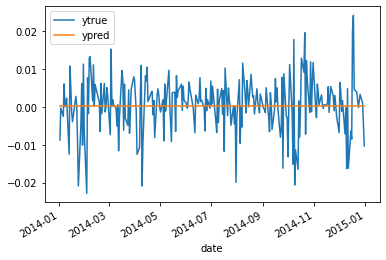

In [152]:
pred_lasso = lasso_search.best_estimator_.predict(X_test)
pred_lasso = pd.concat([pd.DataFrame(y_test), pd.DataFrame(pred_lasso)], axis=1)
pred_lasso.columns = ['ytrue', 'ypred']
pred_lasso.index = oos_index
pred_lasso.plot()

In [153]:
new_r2(pred_lasso['ypred'], pred_lasso['ytrue']) * 100

-38008.88031702993

# Ridge

In [155]:
ridge_search = RandomizedSearchCV(estimator=Ridge(fit_intercept=True),
                                  param_distributions={'alpha': np.linspace(0, 1, 100)},
                                  n_iter=10,
                                  cv=time_split,
                                  verbose=1,
                                  n_jobs=-1,
                                  scoring=r2_scorer)
ridge_search = ridge_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [156]:
ridge_search.best_estimator_

Ridge(alpha=0.8686868686868687)

In [157]:
np.sort(np.abs(ridge_search.best_estimator_.coef_))

array([3.37437287e-07, 7.84957183e-07, 9.66703094e-07, ...,
       1.08064959e-02, 1.09395662e-02, 1.15462776e-02])

<AxesSubplot:xlabel='date'>

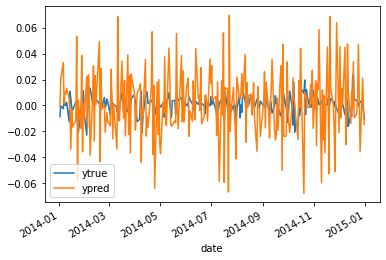

In [158]:
pred_ridge = ridge_search.best_estimator_.predict(X_test)
pred_ridge = pd.concat([pd.DataFrame(y_test), pd.DataFrame(pred_ridge)], axis=1)
pred_ridge.columns = ['ytrue', 'ypred']
pred_ridge.index = oos_index
pred_ridge.plot()

In [159]:
new_r2(pred_ridge['ypred'], pred_ridge['ytrue']) * 100

-0.9357525102843045

# ElasticNet

In [164]:
en_search = RandomizedSearchCV(estimator=ElasticNet(fit_intercept=True),
                                  param_distributions={'alpha': np.linspace(0, 1, 100),
                                                       'l1_ratio': np.linspace(0, 1, 100)},
                                  n_iter=50,
                                  cv=time_split,
                                  verbose=1,
                                  n_jobs=-1,
                                  scoring=r2_scorer)
en_search = en_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [165]:
en_search.best_estimator_

ElasticNet(alpha=0.020202020202020204, l1_ratio=0.27272727272727276)

In [166]:
np.sort(np.abs(en_search.best_estimator_.coef_))

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 1.19503865e-06, 1.36732680e-05])

<AxesSubplot:xlabel='date'>

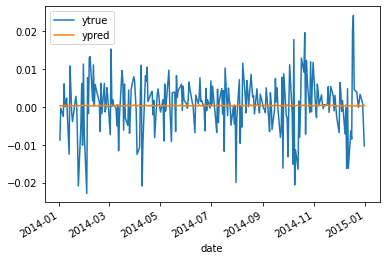

In [167]:
pred_en = en_search.best_estimator_.predict(X_test)
pred_en = pd.concat([pd.DataFrame(y_test), pd.DataFrame(pred_en)], axis=1)
pred_en.columns = ['ytrue', 'ypred']
pred_en.index = oos_index
pred_en.plot()

In [168]:
new_r2(pred_en['ypred'], pred_en['ytrue']) * 100

-37317.932552327315